In [1]:
from nga.utils import load_config, plane_eval_ray_bundle, save_as_image, convert_to_transformed_space
from nerfstudio.utils.eval_utils import eval_load_checkpoint
from nerfstudio.cameras.rays import RayBundle
from nerfstudio.utils import colormaps
from nerfstudio.utils.io import load_from_json

from PIL import Image
from pathlib import Path
import yaml
import torch
import json
import numpy as np
import OpenEXR, Imath
import matplotlib.pyplot as plt

In [2]:


def load_metadata(config):
    if config.data.suffix == ".json":
        meta = load_from_json(config.data)
        data_dir = config.data.parent
    else:
        meta = load_from_json(config.data / "transforms.json")
        data_dir = config.data
    return meta, data_dir

In [9]:
# config_path = "outputs/long_plane_2_cameras/instant-ngp/2023-09-21_180151/config.yml"
# config_path = "outputs/long_plane_2_cameras/nerfacto/2023-09-21_181725/config.yml"
config_path = "outputs/long_plane_2_cameras/tensorf/2023-09-21_173724/config.yml"

plane_dimensions=(5.0,10.0)

config = load_config(config_path)
config.load_dir = config.get_checkpoint_dir()

meta, data_dir = load_metadata(config)


In [10]:

# setup pipeline (which includes the DataManager)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline = config.pipeline.setup(device=device, test_mode="val")
pipeline.eval()


checkpoint_path, step = eval_load_checkpoint(config, pipeline)
results_path = config.get_base_dir() / "results.json"
render_output_path = config.get_base_dir() / "renders"
render_output_path.mkdir(parents=True, exist_ok=True)

[21:32:33] Auto image downscale factor of 1                                                 ]8;id=765105;file:///home/ccl/anaconda3/envs/nerfstudio/lib/python3.8/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=532276;file:///home/ccl/anaconda3/envs/nerfstudio/lib/python3.8/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#349\349]8;;\

            Dataset is overriding train_indices to [2, 3]                                   ]8;id=461764;file:///home/ccl/anaconda3/envs/nerfstudio/lib/python3.8/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=701768;file:///home/ccl/anaconda3/envs/nerfstudio/lib/python3.8/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#200\200]8;;\

            Dataset is overriding val_indices to [4, 5]                                     ]8;id=78104;file:///home/ccl/anaconda3/envs/nerfstudio/lib/python3.8/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=257262;file:///home/ccl/anaconda3/envs/nerfstudio/lib/python3.8/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#200\200]8;;\

Setting up training dataset...

Caching all 2 images.

Output()

Setting up evaluation dataset...

Caching all 2 images.

Output()

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/long_plane_2_cameras/tensorf/2023-09-21_173724/nerfstudio_models/step-000029999.ckpt

In [11]:


depth_filenames = pipeline.datamanager.eval_dataset.metadata["depth_filenames"]

def read_depth_map(file_path):
    exr_file = OpenEXR.InputFile(file_path)
    dw = exr_file.header()['dataWindow']
    width = dw.max.x - dw.min.x + 1
    height = dw.max.y - dw.min.y + 1
    
    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    depth_str = exr_file.channel('R', pt)
    depth = np.frombuffer(depth_str, dtype=np.float32)
    depth.shape = (height, width)  # reshape
    
    return torch.unsqueeze(torch.from_numpy(depth), dim=-1).to(device=device)

# from: https://github.com/kobejean/bts/blob/d4f1de8f9c8f253cc2bcd1ce0d92fce193a72bac/pytorch/bts_eval.py#L91-L112
def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    d1 = (thresh < 1.25).mean()
    d2 = (thresh < 1.25 ** 2).mean()
    d3 = (thresh < 1.25 ** 3).mean()
    
    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())
    
    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())
    
    abs_rel = np.mean(np.abs(gt - pred) / gt)
    sq_rel = np.mean(((gt - pred) ** 2) / gt)
    
    err = np.log(pred) - np.log(gt)
    silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100
    
    err = np.abs(np.log10(pred) - np.log10(gt))
    log10 = np.mean(err)
    
    return silog, log10, abs_rel, sq_rel, rmse, rmse_log, d1, d2, d3

num_images = len(pipeline.datamanager.fixed_indices_eval_dataloader)
depth_silog = np.zeros(num_images, np.float32)
depth_log10 = np.zeros(num_images, np.float32)
depth_rms = np.zeros(num_images, np.float32)
depth_log_rms = np.zeros(num_images, np.float32)
depth_abs_rel = np.zeros(num_images, np.float32)
depth_sq_rel = np.zeros(num_images, np.float32)
depth_d1 = np.zeros(num_images, np.float32)
depth_d2 = np.zeros(num_images, np.float32)
depth_d3 = np.zeros(num_images, np.float32)

for camera_ray_bundle, batch in pipeline.datamanager.fixed_indices_eval_dataloader:
    image_idx = batch["image_idx"]
    depth_filepath = depth_filenames[image_idx]
    depth_gt = read_depth_map(str(depth_filepath))
    mask = depth_gt <= 1000
    depth_gt[depth_gt > 1000] = torch.min(depth_gt[mask])
    outputs = pipeline.model.get_outputs_for_camera_ray_bundle(camera_ray_bundle)

    rgb_pred = outputs["rgb"]
    rgb_gt = batch["image"]
    acc = outputs["accumulation"]
    acc_vis = colormaps.apply_colormap(acc)

    depth_pred = outputs["depth"]

    depth_pred_vis = colormaps.apply_depth_colormap(
        depth_pred,
        accumulation=outputs["accumulation"],
    )
    depth_gt_vis = colormaps.apply_depth_colormap(
        depth_gt,
    )
    depth_gt_vis = torch.concat([depth_gt_vis, mask], dim=-1)
    depth_diff = depth_pred - depth_gt
    depth_diff[depth_gt > 1000] = torch.min(depth_diff[mask])
    depth_diff_vis = colormaps.apply_depth_colormap(
        depth_diff,
    )
    depth_diff_vis = torch.concat([depth_diff_vis, mask], dim=-1)

    save_as_image(rgb_pred, render_output_path / f"rgb_pred_{image_idx:04d}.png")
    save_as_image(rgb_gt, render_output_path / f"rgb_gt_{image_idx:04d}.png")
    save_as_image(acc_vis, render_output_path / f"acc_{image_idx:04d}.png")
    save_as_image(depth_pred_vis, render_output_path / f"depth_pred_{image_idx:04d}.png")
    save_as_image(depth_gt_vis, render_output_path / f"depth_gt_{image_idx:04d}.png")
    save_as_image(depth_diff_vis, render_output_path / f"depth_diff_{image_idx:04d}.png")

    depth_silog[image_idx], depth_log10[image_idx], depth_abs_rel[image_idx], depth_sq_rel[image_idx], depth_rms[image_idx], depth_log_rms[image_idx], depth_d1[image_idx], depth_d2[image_idx], depth_d3[image_idx] = compute_errors(
            depth_gt[mask].to("cpu").numpy(), depth_pred[mask].to("cpu").numpy())
    
    

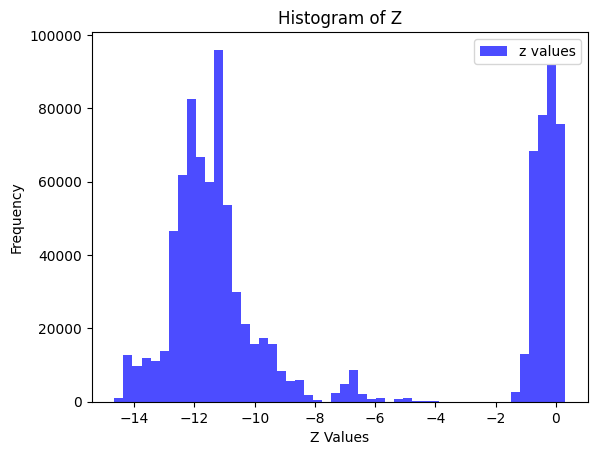

631

In [12]:


# load data for coverting between original and normalized coodinate space
dataparser_transforms_path = config.get_base_dir() / "dataparser_transforms.json"
dataparser_transforms_data = json.load(open(dataparser_transforms_path))
dataparser_scale = dataparser_transforms_data["scale"]
transform = torch.tensor(dataparser_transforms_data["transform"])

sampling_width = 0.5
camera_ray_bundle = plane_eval_ray_bundle(dataparser_transforms_data, sampling_width, dimensions=plane_dimensions).to(device)
outputs = pipeline.model.get_outputs_for_camera_ray_bundle(camera_ray_bundle)

rgb = outputs["rgb"]
depth = outputs["depth"]
mask = depth < 2 * sampling_width
mask = torch.abs(depth - torch.mean(depth)) < 1 * torch.std(depth)
acc = colormaps.apply_colormap(outputs["accumulation"])
depth_vis = torch.clone(depth)
depth_vis[torch.logical_not(mask)] = torch.min(depth[mask])
depth_vis = colormaps.apply_depth_colormap(
    depth_vis,
    accumulation=outputs["accumulation"],
)
depth_vis = torch.concat([depth_vis, mask], dim=-1)

z = sampling_width - (outputs["depth"] / dataparser_scale)
z_vis = torch.clone(z)
z_vis[torch.logical_not(mask)] = torch.min(z[mask])
z_vis = colormaps.apply_depth_colormap(
    z_vis,
    accumulation=outputs["accumulation"],
)
z_vis = torch.concat([z_vis, mask], dim=-1)

save_as_image(rgb, render_output_path / "rgb.png")
save_as_image(acc, render_output_path / "acc.png")
save_as_image(depth_vis, render_output_path / "depth.png")
save_as_image(z_vis, render_output_path / "z.png")
torch.save(z_vis, render_output_path / "z.pt")

plt.hist(z.cpu().numpy().flatten(), bins=50, color='blue', alpha=0.7, label='z values')
plt.xlabel('Z Values')
plt.ylabel('Frequency')
plt.title('Histogram of Z')
plt.legend()
plt.savefig(render_output_path / 'z_hist.jpeg')
plt.show()

# Get the output and define the names to save to
benchmark_info = {
    "experiment_name": config.experiment_name,
    "method_name": config.method_name,
    "checkpoint": str(checkpoint_path),
    "results": {
        "max_z": float(torch.max(z)),
        "min_z": float(torch.min(z)),
        "std_z": float(torch.std(z)),
        "mean_z": float(torch.mean(z)),
        "depth_metrics": {
            "silog": float(depth_silog.mean()),
            "log10": float(depth_log10.mean()),
            "abs_rel": float(depth_abs_rel.mean()),
            "sq_rel": float(depth_sq_rel.mean()),
            "rms": float(depth_rms.mean()),
            "log_rms": float(depth_log_rms.mean()),
            "d1": float(depth_d1.mean()),
            "d2": float(depth_d2.mean()),
            "d3": float(depth_d3.mean()),
        }
    },
}
# Save output to output file
results_path.write_text(json.dumps(benchmark_info, indent=2), "utf8")

MovieWriter imagemagick unavailable; using Pillow instead.


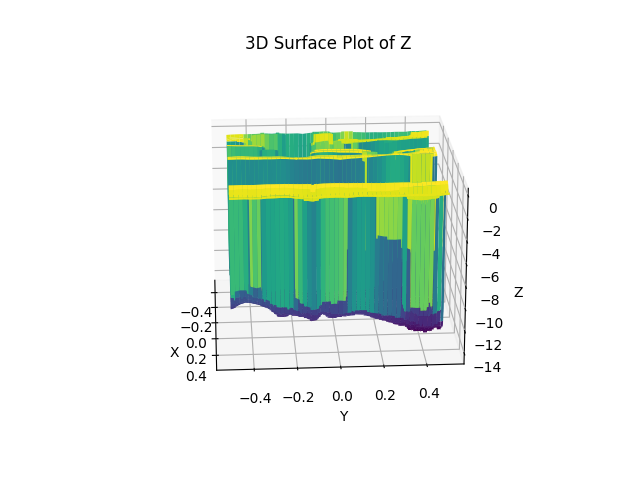

No such comm: 004e64cc478948139169384e034212a1


In [13]:
%matplotlib widget
from matplotlib.animation import FuncAnimation

# Convert PyTorch tensor to NumPy array
z_numpy = z.squeeze().cpu().numpy()

# Create x and y coordinates for 1x1 xy-plane centered at origin
x = np.linspace(-0.5, 0.5, 1001)
y = np.linspace(-0.5, 0.5, 1001)
x, y = np.meshgrid(x, y)

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(x, y, z_numpy, cmap='viridis')

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Surface Plot of Z')

# Function to update the plot at each frame
def update(frame):
    ax.view_init(elev=20., azim=3.6*frame)
    return surface,

# Create animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 100), blit=False, repeat=False)

# To save the animation
ani.save(render_output_path / '3D_rotation.gif', writer='imagemagick')


# Show plot
plt.show()



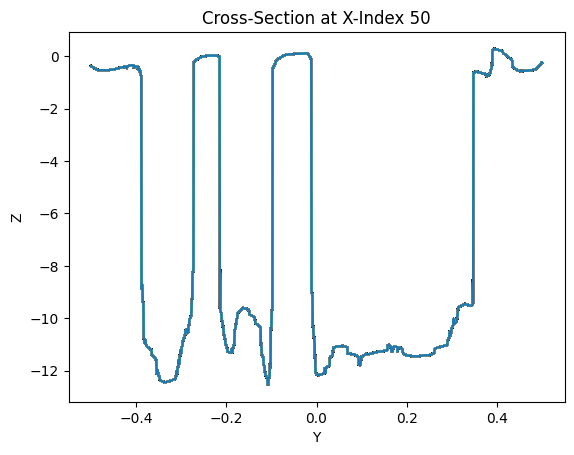

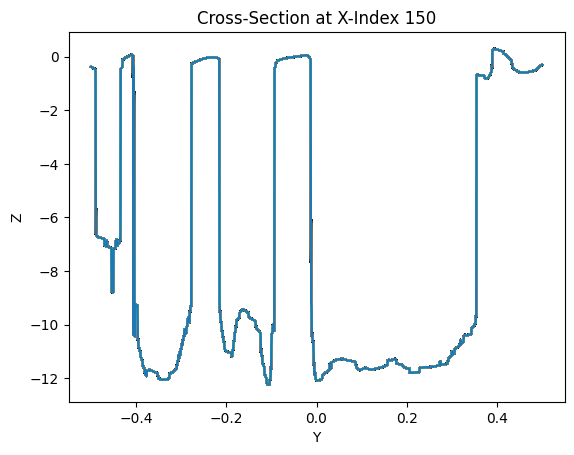

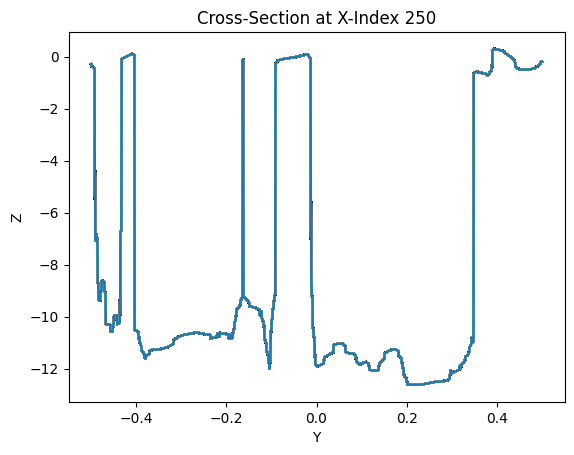

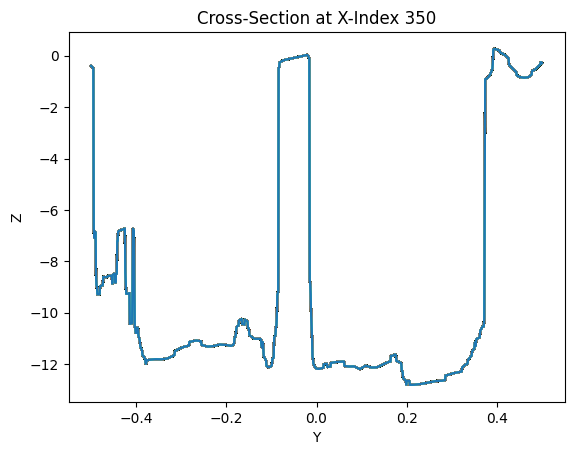

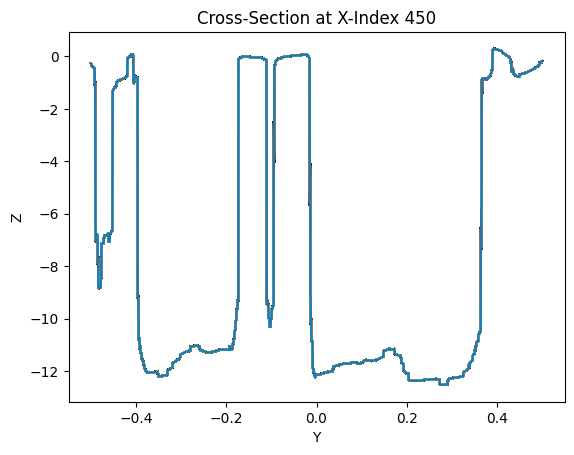

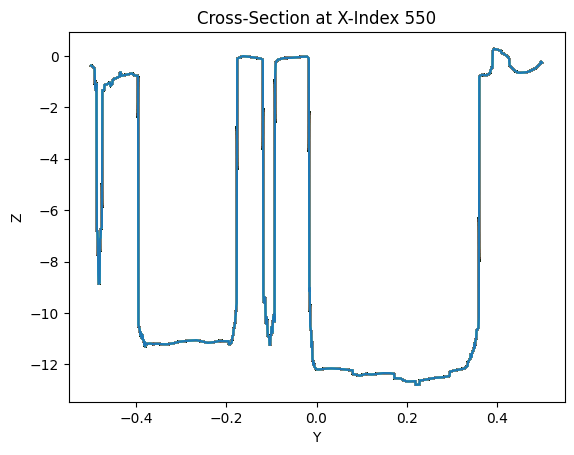

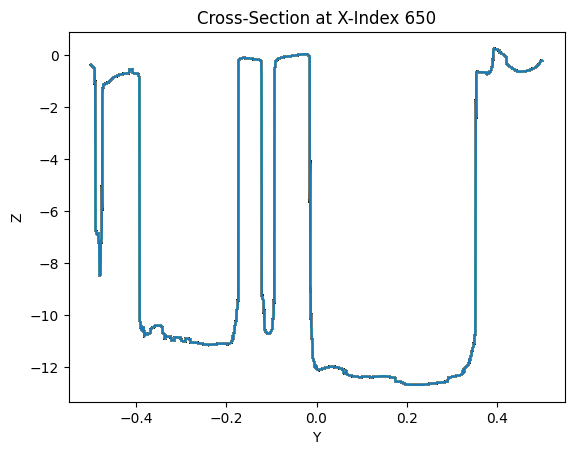

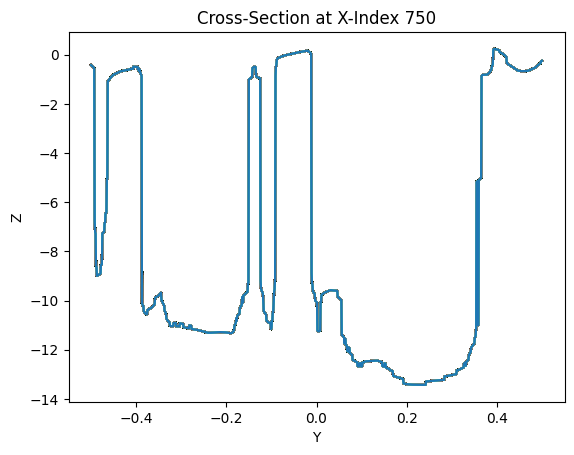

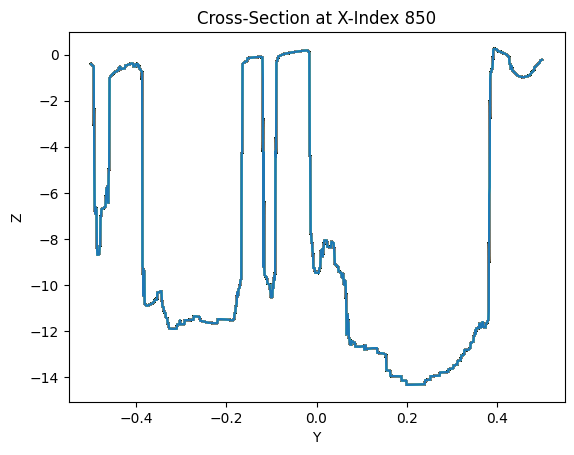

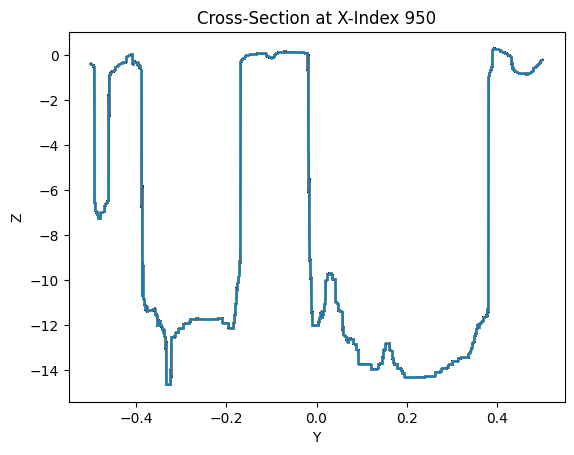

In [14]:
%matplotlib inline
# Number of slices
num_slices = 10

# Create the slices
for i in range(num_slices):
    # Choose an index for the cross-section along the x-axis
    slice_index = int((i + 0.5) * (z_numpy.shape[0] / num_slices))  # Replace this with a suitable value within [0, 1000]

    # Extract the slice
    z_slice = z_numpy[slice_index, :]

    # Plotting
    plt.figure()
    plt.plot(y, z_slice)
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title(f'Cross-Section at X-Index {slice_index}')
    plt.savefig(render_output_path / f'cross_section_{slice_index}.jpeg')
    # plt.show()
